# Fase 2: Clasificación de la ejecución del movimiento

Este Notebook tiene como objetivo principal crear un pipeline que clasifique los gestos realizados como *correctos* o *incorrectos*. Además, aborda los siguientes aspectos clave:

**Cálculo de distancias y caracterización previa de los movimientos**

Se determinan las distancias entre puntos clave del cuerpo y los ángulos de distintas articulaciones en función del gesto que esté realizando el paciente. Por ejemplo, al detectar una flexión del hombro derecho, se calculan las distancias y ángulos relacionados específicamente con ese brazo.

**Aprendizaje automático explicativo**

Se incorpora un análisis explicativo del modelo, destacando las variables que tienen mayor influencia en las decisiones del modelo sobre el conjunto de datos completo.


<div style="text-align: center;">
<img src="../Imagenes/gestures.png" width="500"/>
</div>

***• Importar librerías***

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import functions as fn
import numpy as np

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.model_selection import LeaveOneGroupOut # LeavePGroupsOut
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

## Evaluación de los modelos
from sklearn.metrics import *

## Hiperparametrizacion
from sklearn.model_selection import RandomizedSearchCV

# Class imbalance
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek, SMOTEENN

## Seleccion de variables
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.inspection import permutation_importance

# Explicacion 
from sklearn import tree # visualizar dtree
import shap

# Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

# Suprimir warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

***• Importar datos***

In [7]:
# Dataframe de los datos en bruto
df_raw = pd.read_csv('../Resultados/raw_pacientes.csv', dtype=object)
df_raw

,SubjectID,GestureLabel,GestureName,RepetitionNumber,CorrectLabel,JointName,3D_X,3D_Y,3D_Z
0,102,0,EFL,10,1,SpineBase,-0.08088344,-0.2248836,2.661578
1,102,0,EFL,10,1,SpineMid,-0.06806522,0.04492111,2.628779
2,102,0,EFL,10,1,Neck,-0.055614,0.3082771,2.583972
3,102,0,EFL,10,1,Head,-0.04478608,0.4328104,2.593495
4,102,0,EFL,10,1,ShoulderLeft,-0.2232155,0.2021449,2.549825
...,...,...,...,...,...,...,...,...,...
5500495,307,8,STR,9,1,SpineShoulder,-0.05799517,0.5291457,2.422904
5500496,307,8,STR,9,1,HandTipLeft,-0.302538,-0.1131345,2.284269
5500497,307,8,STR,9,1,ThumbLeft,-0.2783904,-0.06298634,2.269769
5500498,307,8,STR,9,1,HandTipRight,0.1525867,-0.136378,2.45287


***• Funciones creadas***

En el archivo `functions.py` se ha creado la siguiente función:
<small>
```python
def calcular_distancia(df: pd.DataFrame, joint_a: str, joint_b: str):
    # Extraer posiciones de los keypoints
    positions = df.set_index('JointName')[['3D_X', '3D_Y', '3D_Z']].loc[[joint_a, joint_b]]

    # Convertir las posiciones a tipo numérico
    positions = positions.apply(pd.to_numeric)

    # Vector u (joint_a to joint_b) y Vector v (joint_b to joint_c)
    u = np.array([positions.iloc[1, 0] - positions.iloc[0, 0],
                  positions.iloc[1, 1] - positions.iloc[0, 1],
                  positions.iloc[1, 2] - positions.iloc[0, 2]])

    modulo_u = np.linalg.norm(u)

    return modulo_u
```
</small>

In [8]:
# dividir en test y train df_gestures
def split_df_gestures(df:pd.DataFrame, target: str):

    # Selecciona los datos de prueba (varios sujetos)
    test_df = df.loc[(df.SubjectID==102) | (df.SubjectID==105) | (df.SubjectID==201) |
                (df.SubjectID==202) | (df.SubjectID==205) | (df.SubjectID==302)] 

    # Selecciona los datos de entrenamiento excluyendo los mismos sujetos
    train_df = df.loc[(df.SubjectID!=102) & (df.SubjectID!=105)  & (df.SubjectID!=201) &
                    (df.SubjectID!=202) & (df.SubjectID!=205) & (df.SubjectID!=302)]

    # Separa las características y las etiquetas en el conjunto de entrenamiento
    X_train = train_df.drop([target], axis=1)  
    y_train = pd.DataFrame(train_df[target])   

    # Separa las características y las etiquetas en el conjunto de prueba
    X_test = test_df.drop([target], axis=1)  
    y_test = pd.DataFrame(test_df[target])   

    # Convierte los DataFrames de etiquetas a arrays 1D
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()

    # Devuelve los conjuntos de entrenamiento y prueba
    return X_train, X_test, y_train, y_test

***• Caracterización previa de los movimientos y Pipeline***

In [9]:
# Definir la malla de parámetros
param_grid = [
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [2, 3, 5], 
        'classifier__weights': ['uniform', 'distance'], 
        'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']  
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [DecisionTreeClassifier()],
        'classifier__criterion': ['gini', 'entropy'],
        'classifier__max_depth': [None, 10, 20, 30]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [GaussianNB()],
        'classifier__var_smoothing': np.logspace(0, -8, num=100)
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [SVC(probability=True)],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'classifier__C': [0.1, 1, 10, 100]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [RandomForestClassifier()],
        'classifier__n_estimators': [200, 300],
        'classifier__max_features': ['sqrt', 'log2']
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [LogisticRegression(max_iter=500)],
        'classifier__C': [0.01, 0.1, 1, 10, 100]
    },
    {
        'balance_data': [SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0)),
                         SMOTEENN(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))],
        'balance_data__smote__k_neighbors': [3, 4],
        'select_features__k': list(range(5, 15)),
        'classifier': [MLPClassifier()],
        'classifier__hidden_layer_sizes': [(2,3,2), (5,10,5), (10,20,10), (15,25,15), (20,30,20)],
        'classifier__activation': ['relu', 'tanh', 'logistic'],
        'classifier__solver': ['sgd', 'adam'],
        'classifier__alpha': [0.0001, 0.001, 0.01, 0.05, 0.1],
        'classifier__learning_rate': ['constant', 'invscaling', 'adaptive']
    }
]


------------ CLASIFICACION GESTO Flexión del codo izquierdo -----------

Pipeline(steps=[('balance_data',
                 SMOTETomek(smote=SMOTE(k_neighbors=3, sampling_strategy=1.0))),
                ('select_features', SelectKBest(k=8)),
                ('classifier',
                 MLPClassifier(alpha=0.01, hidden_layer_sizes=(2, 3, 2),
                               solver='sgd'))])
F1-score del conjunto de entrenamiento: 0.19289340101522842
Informe de clasificación (conjunto de prueba):
              precision    recall  f1-score   support

           1       0.00      0.00      0.00        45
           2       0.13      1.00      0.24         7

    accuracy                           0.13        52
   macro avg       0.07      0.50      0.12        52
weighted avg       0.02      0.13      0.03        52



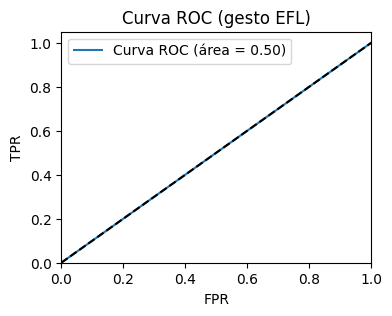

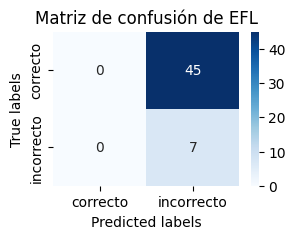

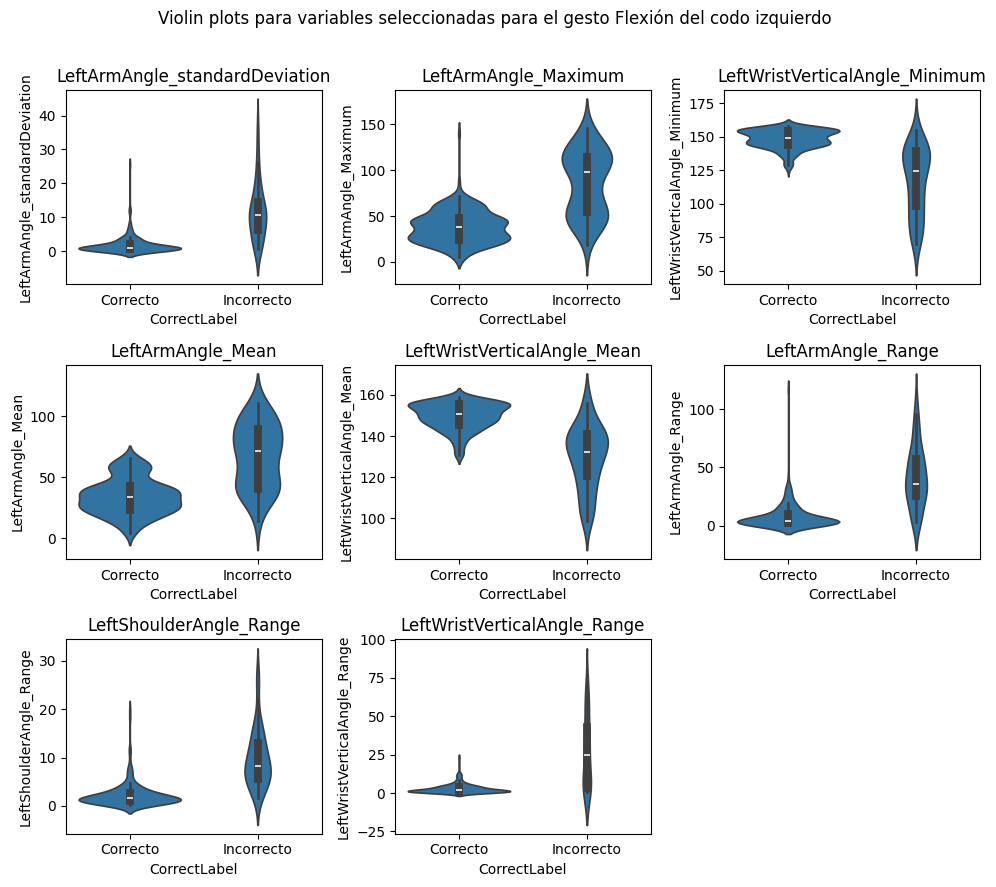

<Figure size 640x480 with 0 Axes>

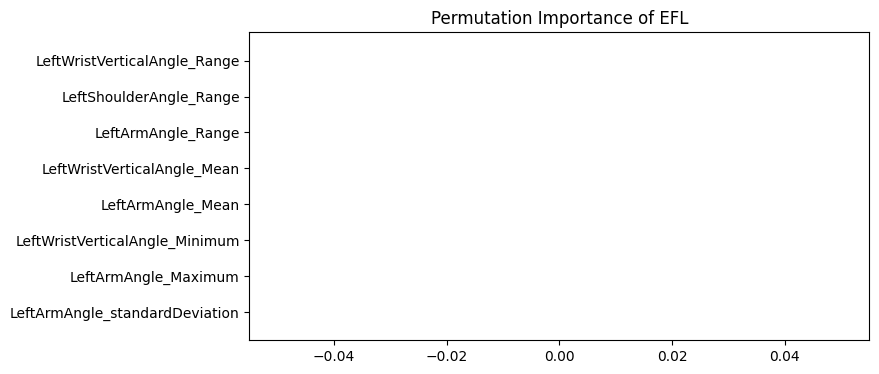

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: MLPClassifier(alpha=0.01, hidden_layer_sizes=(2, 3, 2), solver='sgd')

In [ ]:
gestures = df_raw['GestureName'].unique()
logo = LeaveOneGroupOut()
results = []
gesture_name_mapping = {
    'EFL': 'Flexión del codo izquierdo',
    'EFR': 'Flexión del codo derecho',
    'SFL': 'Flexión del hombro izquierdo',
    'SFR': 'Flexión del hombro derecho',
    'SAL': 'Abducción del hombro izquierdo',
    'SAR': 'Abducción del hombro derecho',
    'SFE': 'Elevación frontal del hombro',
    'STL': 'Toque lateral izquierdo',
    'STR': 'Toque lateral derecho'
}

for gesture in gestures:
    df_gesture = df_raw[df_raw['GestureName'] == gesture]
    gesture_name = gesture_name_mapping.get(gesture)

    calculations = []

    #------- Calcular angulos y distancia segun gesto ---------
    # gestos con brazo izquierdo
    if gesture == 'EFL' or gesture == 'SFL' or gesture == 'SAL' or gesture == 'SFE':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName',
                                             'RepetitionNumber', 'CorrectLabel']]

            left_arm_angle = fn.calculate_angle(group, 'ShoulderLeft', 'ElbowLeft', 'WristLeft')
            left_armpit_angle = fn.calculate_angle(group, 'HipLeft', 'ShoulderLeft', 'ElbowLeft')
            left_wrist_angle = fn.calculate_angle(group, 'ElbowLeft', 'WristLeft', 'HandLeft')
            left_wrist_vertical_angle = fn.calculate_angle(group, 'SpineBase', 'SpineShoulder', 'WristLeft')
            left_elbow_vertical_angle = fn.calculate_angle(group, 'SpineBase', 'SpineShoulder', 'ElbowLeft')
            left_shoulder_angle = fn.calculate_angle(group, 'ShoulderLeft', 'SpineShoulder', 'ElbowLeft')

            shoulders_distance = fn.calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            hips_distance = fn.calcular_distancia(group, 'HipLeft', 'HipRight')
            foots_distance = fn.calcular_distancia(group, 'FootLeft', 'FootRight')
            head_distance = fn.calcular_distancia(group, 'SpineShoulder', 'Head')

            calculations.append({
                **additional_data,
                'LeftArmAngle': left_arm_angle,
                'LeftArmpitAngle': left_armpit_angle,
                'LeftWristAngle': left_wrist_angle,
                'LeftWristVerticalAngle': left_wrist_vertical_angle,
                'LeftElbowVerticalAngle': left_elbow_vertical_angle,
                'LeftShoulderAngle': left_shoulder_angle,
                'ShouldersDistance': shoulders_distance,
                'HipsDistance': hips_distance,
                'FootsDistance': foots_distance,
                'HeadDistance': head_distance
            })

    # gestos con brazo derecho
    elif gesture == 'EFR'or gesture == 'SFR' or gesture == 'SAR':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName',
                                             'RepetitionNumber', 'CorrectLabel']]

            right_arm_angle = fn.calculate_angle(group, 'ShoulderRight', 'ElbowRight', 'WristRight')
            right_armpit_angle = fn.calculate_angle(group, 'HipRight', 'ShoulderRight', 'ElbowRight')
            right_wrist_angle = fn.calculate_angle(group, 'ElbowRight', 'WristRight', 'HandRight')
            right_wrist_vertical_angle = fn.calculate_angle(group, 'SpineBase', 'SpineShoulder', 'WristRight')
            right_elbow_vertical_angle = fn.calculate_angle(group, 'SpineBase', 'SpineShoulder', 'ElbowRight')
            right_shoulder_angle = fn.calculate_angle(group, 'ShoulderRight', 'SpineShoulder', 'ElbowRight')

            shoulder_distance = fn.calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            hips_distance = fn.calcular_distancia(group, 'HipLeft', 'HipRight')
            foots_distance = fn.calcular_distancia(group, 'FootLeft', 'FootRight')

            calculations.append({
                **additional_data,
                'RightArmAngle': right_arm_angle,
                'RightArmpitAngle': right_armpit_angle,
                'RightWristAngle': right_wrist_angle,
                'RightWristVerticalAngle': right_wrist_vertical_angle,
                'RightElbowVerticalAngle': right_elbow_vertical_angle,
                'RightShoulderAngle': right_shoulder_angle,
                'ShouldersDistance': shoulder_distance,
                'HipsDistance': hips_distance,
                'FootsDistance': foots_distance,
                'HeadDistance': head_distance
            })
    
    # gestos con pierna izquierda
    elif gesture == 'STL':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName',
                                             'RepetitionNumber', 'CorrectLabel']]

            hip_angle_left = fn.calculate_angle(group, 'HipLeft', 'SpineBase', 'KneeLeft')
            knee_angle_left = fn.calculate_angle(group, 'HipLeft', 'KneeLeft', 'AnkleLeft')
            ankle_angle_left = fn.calculate_angle(group, 'KneeLeft', 'AnkleLeft', 'FootLeft')
            between_knees_angle = fn.calculate_angle(group, 'KneeLeft', 'SpineBase', 'KneeRight')
            between_ankles_angle = fn.calculate_angle(group, 'AnkleLeft', 'SpineBase', 'AnkleRight')
            between_foots_angle = fn.calculate_angle(group, 'FootLeft', 'SpineBase', 'FootRight')

            elbows_distance = fn.calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            head_distance = fn.calcular_distancia(group, 'SpineShoulder', 'Head')

            calculations.append({
                **additional_data,
                'HipAngleLeft': hip_angle_left,
                'KneeAngleLeft': knee_angle_left,
                'AnkleAngleLeft': ankle_angle_left,
                'BetweenKneesAngle': between_knees_angle,
                'BetweenAnkleAngle': between_ankles_angle,
                'BetweenFootsAngle': between_foots_angle,
                'ShouldersDistance': shoulder_distance,
                'HeadDistance': head_distance
            })
    
    # gestos con pierna derecha
    elif gesture == 'STR':
        for _, group in df_gesture.groupby(np.arange(len(df_gesture)) // 25):
            additional_data = group.iloc[0][['SubjectID', 'GestureLabel', 'GestureName',
                                             'RepetitionNumber', 'CorrectLabel']]

            hip_angle_right = fn.calculate_angle(group, 'HipRight', 'SpineBase', 'KneeRight')
            knee_angle_right = fn.calculate_angle(group, 'HipRight', 'KneeRight', 'AnkleRight')
            ankle_angle_right = fn.calculate_angle(group, 'KneeRight', 'AnkleRight', 'FootRight')
            between_knees_angle = fn.calculate_angle(group, 'KneeLeft', 'SpineBase', 'KneeRight')
            between_ankles_angle = fn.calculate_angle(group, 'AnkleLeft', 'SpineBase', 'AnkleRight')
            between_foots_angle = fn.calculate_angle(group, 'FootLeft', 'SpineBase', 'FootRight')

            shoulder_distance = fn.calcular_distancia(group, 'ShoulderLeft', 'ShoulderRight')
            head_distance = fn.calcular_distancia(group, 'SpineShoulder', 'Head')

            calculations.append({
                **additional_data,
                'HipAngleRight': hip_angle_right,
                'KneeAngleRight': knee_angle_right,
                'AnkleAngleRight': ankle_angle_right,
                'BetweenKneesAngle': between_knees_angle,
                'BetweenAnkleAngle': between_ankles_angle,
                'BetweenFootsAngle': between_foots_angle,
                'ShouldersDistance': shoulder_distance,
                'HeadDistance': head_distance
            })

    df_calculations = pd.DataFrame(calculations)

    # ----- Cálculos estadísticos para agrupar por repeticion --------
    groups = df_calculations.groupby(["SubjectID", "RepetitionNumber"])
    data = []


    for (subject_id, repetition_number), group in groups:
        # Selecciona solo las columnas que contienen los ángulos 
        df_calculations = group.iloc[:, 5:]

        # Separar en ángulos y distancias
        distance_columns = df_calculations.filter(regex=r'\b.*Distance\b').columns
        df_angles = df_calculations.drop(columns=distance_columns)

        # Calculos estadísticos
        means = df_angles.mean()

        data.append({
            'SubjectID': subject_id,
            'RepetitionNumber': repetition_number,
            'CorrectLabel': group['CorrectLabel'].iloc[0],
            'Duration': len(group),  # Duración en número de frames
            'standardDeviation': df_calculations.std(),
            'Maximum': df_angles.max(),
            'Minimum': df_angles.min(),
            'Mean': means,
            'Range': df_angles.max() - df_angles.min(),
            'Variance': df_angles.var(),
            'CoV': df_angles.std() / means,  # Coeficiente de variación
            'Skewness': df_angles.skew(),  # Asimetría
            'Kurtosis': df_angles.kurtosis()  # Curtosis
        })

    # ordenar y formatear df
    df_stats = pd.DataFrame(data)
    df_stats = df_stats.apply(pd.to_numeric, errors='ignore')
    df_stats = df_stats.sort_values(['RepetitionNumber'])

    columnas = ['standardDeviation', 'Maximum', 'Minimum', 'Mean', 'Range',
                    'Variance', 'CoV', 'Skewness', 'Kurtosis']
    nuevas_columnas = pd.concat([fn.formatear_columnas(df_stats[col], col)
                                 for col in columnas], axis=1)
    df_stats = pd.concat([df_stats, nuevas_columnas], axis=1)
    df_stats = df_stats.drop(columnas, axis=1)

    # cambiar las poorly executed to incorrectly executed
    df_stats.loc[df_stats['CorrectLabel'] == 3, 'CorrectLabel'] = 2

    # --------- Copia fase 2 ---------
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = split_df_gestures(df_stats, 'CorrectLabel')
    print(f'\n------------ CLASIFICACION GESTO {gesture_name} -----------\n')

    # Crear el pipeline
    pipeline = ImbPipeline([
        ('balance_data', SMOTETomek(smote=SMOTE(k_neighbors=2, sampling_strategy=1.0))),
        ('select_features', SelectKBest(score_func=f_classif)),
        ('classifier', KNeighborsClassifier(n_neighbors=2))
    ])
    
    # mejores hiperparámetros
    random = RandomizedSearchCV(pipeline, param_grid, cv=logo, n_jobs=-1, n_iter=15, scoring='roc_auc')
    random.fit(X_train, y_train, groups=X_train['SubjectID'])
    
    # Mejor pipeline encontrado
    best_pipeline = random.best_estimator_
    print(best_pipeline)

    # Evaluar el modelo
    f1_score_train = best_pipeline.score(X_train, y_train)
    f1_score_test = best_pipeline.score(X_test, y_test)
    print(f'F1-score del conjunto de entrenamiento: {f1_score_train}')
    prediction = best_pipeline.predict(X_test)
    print("Informe de clasificación (conjunto de prueba):")
    print(classification_report(y_test, prediction)) 
    
    # Calcular la curva ROC
    y_prob = best_pipeline.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_prob, pos_label=2)
    roc_auc = auc(fpr, tpr)
    
    # Graficar la curva ROC
    plt.figure(figsize=(4, 3))  
    plt.plot(fpr, tpr, label=f'Curva ROC (área = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(f'Curva ROC (gesto {gesture})')
    plt.legend()
    plt.show()

    # Matriz de confusión
    prediction = best_pipeline.predict(X_test)
    cm = confusion_matrix(y_test, prediction)
    cm_df = pd.DataFrame(cm, index=['correcto', 'incorrecto'], columns=['correcto', 'incorrecto'])
    plt.figure(figsize=(3, 2))
    ax = sns.heatmap(cm_df, annot=True, cmap="Blues", fmt="d")
    ax.set_title(f'Matriz de confusión de {gesture}')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    plt.show()

    # Variables seleccionadas
    feature_names = X_train.columns

    select_kbest = best_pipeline.named_steps['select_features']
    selected_features_mask = select_kbest.get_support()
    selected_features = feature_names[selected_features_mask]
    selected_features = [name.replace('remainder__', '') for name in selected_features]
    selected_features = [name.replace('encoder__', '') for name in selected_features]

    df_selected = df_stats[selected_features]
  
    y = df_stats['CorrectLabel'] 
    y_mapped = y.map({1: 'Correcto', 2: 'Incorrecto'})

    # Violin plots
    n_features = len(selected_features)
    n_cols = 3  
    n_rows = (n_features + n_cols - 1) // n_cols 
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
    axes = axes.flatten()

    for i, feature in enumerate(selected_features):
        sns.violinplot(x=y_mapped, y=df_selected[feature], ax=axes[i])
        axes[i].set_title(f'{feature}') 
        axes[i].set_xlabel('CorrectLabel')
        axes[i].set_ylabel(feature)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(f'Violin plots para variables seleccionadas para el gesto {gesture_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Prevent the supertitle from overlapping
    plt.show()

    # Visualizar los clasificadores
    classifier = best_pipeline.named_steps['classifier']
    classifier_name = classifier.__class__.__name__

    if classifier_name == 'GaussianNB':
        # Extract means and variances
        means = classifier.theta_
        variances = classifier.var_

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 3 * n_rows))
        axes = axes.flatten()
    
        for i, feature in enumerate(selected_features):
            axes[i].errorbar([0, 1], means[:, i], yerr=np.sqrt(variances[:, i]),
                             fmt='o', capsize=5, color='#9b59b6', ecolor='gray')
            for j in range(2):  
                axes[i].text(j+0.03, means[j, i], f'{means[j, i]:.2f}', 
                     ha='left', va='center', fontsize=10, color='blue')
            axes[i].set_title(f'{feature}')
            axes[i].set_xticks([0, 1])
            axes[i].set_xticklabels(['Correcto', 'Incorrecto'])
            axes[i].set_ylabel('Media ± Std Dev')

        for j in range(i + 1, len(axes)):
            fig.delaxes(axes[j])

    elif classifier_name == 'DecisionTreeClassifier':
        fig = plt.figure(figsize=(8, 6), dpi=300) 
        tree.plot_tree(classifier,
                        feature_names=selected_features,
                        class_names=np.unique(y_mapped.values).astype(str),
                        filled=True)

    elif classifier_name == 'LogisticRegression':
        coefficients = classifier.coef_[0]
        plt.figure(figsize=(10, 6))
        plt.barh(selected_features, coefficients)
        plt.xlabel("Valor del coeficiente")
        plt.title("Importancia de las características en la regresión logística")
        plt.axvline(x=0, color="grey", linestyle="--")
      
    elif classifier_name == 'RandomForestClassifier':
        fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
        for index in range(0, 5):
            tree.plot_tree(classifier.estimators_[index],
                        feature_names=selected_features, 
                        class_names=np.unique(y_mapped.values).astype(str),
                        filled = True,
                        ax = axes[index])
        axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
        plt.tight_layout()

    elif classifier_name == 'SVC' and classifier.kernel == 'linear':
        weights = classifier.coef_[0]
        plt.figure(figsize=(10, 6))
        plt.barh(selected_features, weights, color='blue')
        plt.axvline(x=0, color='grey', linestyle='--')
        plt.xlabel("Valor del peso (Importancia de la característica)")
        plt.title("Importancia de las características en el clasificador SVC")

    fig.suptitle(f'Importancia de las variables para {classifier_name}')
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Prevent the supertitle from overlappinge
    plt.show()

    # Permutation Importance
    perm_importance = permutation_importance(classifier, df_selected, y, scoring='f1',n_repeats=10)
    sorted_idx = perm_importance.importances_mean.argsort()
    fig = plt.figure(figsize=(8, 4))
    plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), np.array(df_selected.columns)[sorted_idx])
    plt.title(f'Permutation Importance of {gesture}')
    plt.show()

    #SHAP
    explainer = shap.Explainer(classifier)
    shap_values = explainer(df_selected)
    shap.plots.beeswarm(shap_values)

    # Guardar resultados evaluacion
    results.append({
        'Gesto': gesture,
        'Classifier': classifier_name,
        'K': select_kbest.k,
        'F1-score train': f1_score_train,
        'F1-score test': f1_score_test,
        'AUC': roc_auc
    })

    # ------ Guardar el pipeline entrenado --------
    filename = f'../Resultados/modelo_{gesture}.sav'
    joblib.dump(best_pipeline, filename)

***• Resumen resultados***

In [ ]:
pd.DataFrame(results)